In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import math
import matplotlib.pyplot as plt

# Some hyper-parameters
batch_size = 64
num_epochs = 10
random_seed = 42

# **Preparing the data**

In [2]:
import cifar_utils

cifar_info = cifar_utils.get_info()
print(cifar_info)

# Number of classes
num_classes = cifar_info.features['label'].num_classes

# Number of train/val imgs
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

# Number of train/val steps per epoch
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteRDFC44/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteRDFC44/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000

# **Fetching and Training TF Hub Models**

## **Building an Inception Classifier with TF Hub**

In [3]:
module_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2'
inception_expected_input_shape = [299, 299, 3]
inception_expected_output_shape = [2048]

With the latest versions of `tensorflow-hub`, one can directly fetch the model and its pre-trained weights from TF Hub and instantiate the model as a Keras layer.

In [4]:
feature_extractor = hub.KerasLayer(module_url,
                                   trainable=False,
                                   output_shape=inception_expected_output_shape,
                                   input_shape=inception_expected_input_shape,
                                   dtype=tf.float32)

This layer can be used like any other. We can append to it new fully-connected layers leading the predictions for our different task.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

inception_model = Sequential([feature_extractor,
                              Dense(num_classes, activation='softmax',
                                    name='logits_pred')], 
                             name='inception_tf_hub')

In [6]:
inception_model.summary()

Model: "inception_tf_hub"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
logits_pred (Dense)          (None, 100)               204900    
Total params: 22,007,684
Trainable params: 204,900
Non-trainable params: 21,802,784
_________________________________________________________________


All the paremeters of the pre-trained feature extractor are fixed as `non-trainable/frozen`. We just training the final dense layer, we can still obtain a performant *CIFAR* classifier thanks to transfer learning.

In [7]:
inception_model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0>]

## **Training the TF Hub Inception Classifier**

In [8]:
# Dataset
train_cifar_dataset = cifar_utils.get_dataset('train', batch_size=batch_size,
                                              num_epochs=num_epochs, shuffle=True,
                                              input_shape=inception_expected_input_shape,
                                              return_batch_as_tuple=True,
                                              seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset('val', batch_size=batch_size,
                                            num_epochs=num_epochs, shuffle=False,
                                            input_shape=inception_expected_input_shape,
                                            return_batch_as_tuple=True,
                                            seed=random_seed)

In [9]:
from keras_custom_callbacks import SimpleLogCallback

metrics_to_print = {'loss': 'loss', 'v-loss': 'val_loss', 'acc': 'acc', 
                    'v-acc': 'val_acc', 'top5-acc': 'top5_acc',
                    'v-top5-acc': 'val_top5_acc'}

callbacks = [tf.keras.callbacks.EarlyStopping(patience=8),
             SimpleLogCallback(metrics_to_print, num_epochs, 1)]

metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
           tf.keras.metrics.SparseTopKCategoricalAccuracy(name='top5_acc')]
      
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy()

inception_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

inception_model.fit(train_cifar_dataset, epochs=num_epochs, verbose=0,
                    callbacks=callbacks, validation_data=val_cifar_dataset,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_steps=val_steps_per_epoch)

Training: start
Epoch  0/10: loss = 1.9035; v-loss = 1.3753; acc = 0.5119; v-acc = 0.6169; top5-acc = 0.7937; v-top5-acc = 0.8767
Epoch  1/10: loss = 1.3782; v-loss = 1.3044; acc = 0.6174; v-acc = 0.6339; top5-acc = 0.8771; v-top5-acc = 0.8886
Epoch  2/10: loss = 1.2540; v-loss = 1.2553; acc = 0.6479; v-acc = 0.6440; top5-acc = 0.8954; v-top5-acc = 0.8958
Epoch  3/10: loss = 1.1851; v-loss = 1.2505; acc = 0.6607; v-acc = 0.6511; top5-acc = 0.9032; v-top5-acc = 0.8962
Epoch  4/10: loss = 1.1348; v-loss = 1.2591; acc = 0.6745; v-acc = 0.6512; top5-acc = 0.9121; v-top5-acc = 0.8965
Epoch  5/10: loss = 1.0850; v-loss = 1.2324; acc = 0.6878; v-acc = 0.6599; top5-acc = 0.9164; v-top5-acc = 0.8963
Epoch  6/10: loss = 1.0440; v-loss = 1.2680; acc = 0.6985; v-acc = 0.6552; top5-acc = 0.9233; v-top5-acc = 0.8950
Epoch  7/10: loss = 1.0211; v-loss = 1.2235; acc = 0.7043; v-acc = 0.6590; top5-acc = 0.9260; v-top5-acc = 0.9005
Epoch  8/10: loss = 0.9936; v-loss = 1.2661; acc = 0.7104; v-acc = 0.655

Epoch  9/10: loss = 0.9759; v-loss = 1.2321; acc = 0.7139; v-acc = 0.6627; top5-acc = 0.9323; v-top5-acc = 0.9039
Training: end


## **Predicting with the Inception Classifier**

(16, 224, 224, 3)
Inception Predictions


/content/classification_utils.py:87: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()  # `tight_layout()` similar to `constrained_layout = True`


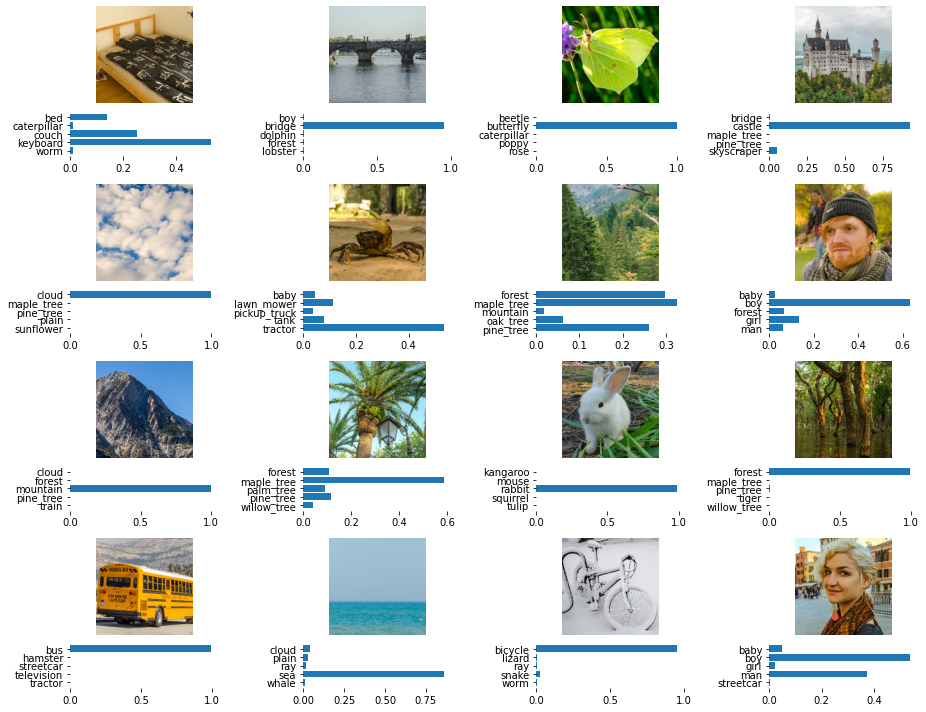

In [13]:
import glob
from classification_utils import load_image, process_predictions, display_predictions

test_filenames = glob.glob(os.path.join('drive/MyDrive/res', '*'))
test_images = np.asarray([load_image(filename, 
                                     inception_expected_input_shape[:-1]) 
                          for filename in test_filenames])
print(test_images.shape)

image_batch = test_images[:16]
class_readable_labels = cifar_info.features['label'].names

# Resize all images to 32x32px (CIFAR images size) and keep resizing to model's
# expected size.
cifar_original_img_size = cifar_info.features['image'].shape[:-1]
image_batch_low_quality = tf.image.resize(image_batch, cifar_original_img_size)
image_batch_low_quality = tf.image.resize(image_batch_low_quality,
                                          inception_expected_input_shape[:-1])

# Predicting 
predictions = inception_model.predict_on_batch(image_batch_low_quality)



top5_labels, top5_probabilities = process_predictions(predictions,
                                                     class_readable_labels,
                                                     5)

print('Inception Predictions')
display_predictions(image_batch, top5_labels, top5_probabilities)